[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nlcuccia/AM216/blob/master/HW1/P1_2.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# Problem 1

Import the data: 1000 data points of type (x,y)

In [2]:
data = np.loadtxt('Problem1.txt')
data.shape # check the shape of our dataset

(1000, 2)

Split the data in train and test data. 60% and 40% is a reasonable splitting.


In [3]:
train_data = data[:600]
test_data = data[600:]

Note that our data were not sorted in an increasing order in x. If it is not the case, a trick is to use `random.shuffle(data)` before splitting.

In [4]:
# assign x's and y's for the train and the test data
x_train = train_data[:,0].reshape(600,1)
y_train = train_data[:,1].reshape(600,1)
x_test = test_data[:,0].reshape(400,1)
y_test = test_data[:,1].reshape(400,1)

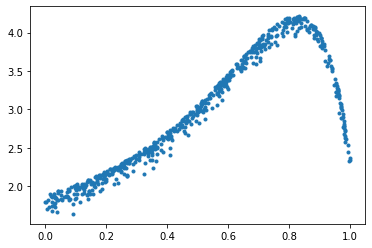

In [5]:
# visualize
plt.plot(x_train,y_train,'.')

In [6]:
def poly_basis(x, d):
    """Returns a polynomial of degree d-1.  
    
    Args:
        x: data array, that is n x 1
        d: degree of the polynomial
    Returns:
        coefficient matrix of the polynomials n x d """
    return np.power(x, np.arange(0, d))

We know that our unknown polynomial is of order 10. The function `poly_basis` returns a polynome of order d-1, so we set d=11. 

In [7]:
d = 11
linReg = linear_model.LinearRegression() # create linear regression object
answer = linReg.fit(poly_basis(x_train,d), y_train) # find coefficients for the polynomial fit
y_fit = answer.predict(poly_basis(x_train,d))

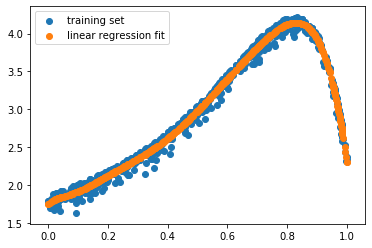

In [8]:
plt.scatter(x_train,y_train, label = 'training set')
plt.scatter(x_train,y_fit, label = 'linear regression fit')
plt.legend()

In [9]:
y_fit = answer.predict(poly_basis(x_test,d))

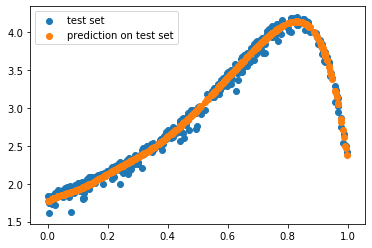

In [10]:
plt.scatter(x_test,y_test, label = 'test set')
plt.scatter(x_test,y_fit, label = 'prediction on test set')
plt.legend()

### We have so far only used the simple linear regression formula. How well did we do?

#### Use your imagination to test your results!

Here's one simple test: plot the difference between the test set and the linear regression fit. 

Is there a trend? What does that tell us?

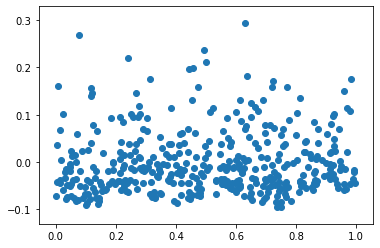

In [11]:
plt.scatter(x_test,y_fit-y_test)

Let's compute the cost function.

In [12]:
def cost_noreg(y_fit,y_real):
    n = len(y_fit) # number of training examples
    return 1/n * (np.linalg.norm(y_fit-y_real))**2

In [13]:
cost_noreg(y_fit,y_test)

0.004542403302998066

Keep improving! Try different regularizations, different splitting of the train and test sets, explore python packages, have fun!

In [14]:
shuf_data = np.copy(data)
# Try 10 different training data splits and look how the cost changes
cost_list = []
for i in range(10):
    # Shuffle data and create new splits
    np.random.shuffle(shuf_data)
    shuf_train_data = shuf_data[:600]
    shuf_test_data = shuf_data[600:]
    shuf_x_train = shuf_train_data[:,0].reshape(600,1)
    shuf_y_train = shuf_train_data[:,1].reshape(600,1)
    shuf_x_test = shuf_test_data[:,0].reshape(400,1)
    shuf_y_test = shuf_test_data[:,1].reshape(400,1)
    
    # Create a polynomial fit using linear regression
    shuf_linReg = linear_model.LinearRegression() 
    shuf_answer = shuf_linReg.fit(poly_basis(shuf_x_train,d), shuf_y_train)
    
    # Test the fit and calculate the cost
    shuf_y_fit = answer.predict(poly_basis(shuf_x_test,d))
    iter_cost = cost_noreg(shuf_y_fit,shuf_y_test)
    cost_list.append(iter_cost)

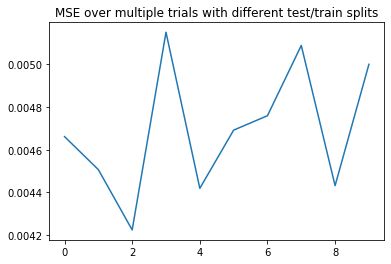

In [15]:
plt.plot(cost_list)
plt.title("MSE over multiple trials with different test/train splits")
plt.show()

Looking at the plot of our cost function for different test/train splits, we can see that there is not a significant change in the cost function. This is good, as we would be suspicious of our model if the cost function varied greatly. 

In [16]:
my_coefs = shuf_answer.coef_
print("Predicted Coefs: " + str(my_coefs))

Predicted Coefs: [[ 0.00000000e+00  3.75305009e+00 -4.38968773e+01  3.90550560e+02
  -1.78253494e+03  4.66785367e+03 -7.13394534e+03  6.13436920e+03
  -2.51155289e+03  1.29067494e+02  1.46851752e+02]]


# Problem 2

#### This time we give you noisy data from an unknown function. Load the data and do your best to find out what function we used.

In [17]:
new_data = np.loadtxt('Problem2.txt')
new_data = np.array(sorted(list(new_data), key=lambda x: x[0]))

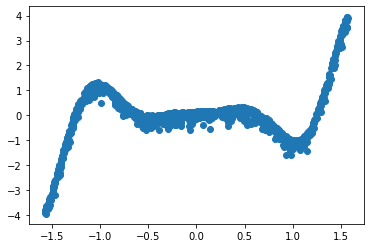

In [18]:
data_plt = plt.scatter(new_data[:,0],new_data[:,1])

Looking at the data, we can immediatly eliminate the possibility of a monotonically increasing/decreasing function. It also appears to be symmetric about the origin, meaning it is likely an odd function. This makes me think that it is either some sort of odd polynomial or sinusoidal function that is being amplified as $|x|$ increases. Another interesting feature is that the top of the "line" formed by all the points is relatively smooth compared to the bottom of the "line" which is much noisier. This likely gives us a clue about how noise was added, as it appears that outliers are only occuring in the negative direction. Let's take a look at the values of $y$ around $x=0$, since we know that $\vec y \approx \vec0$ near the origin under the assumption that this function is an odd function. Let's also plot a histogram of the values to visualize their distribution.

We will also ignore testing training splits since we really just want to kno the function, and are not creating a model to be employed on other data. However, in doing so it is very important to keep an eye out for over-fitting.

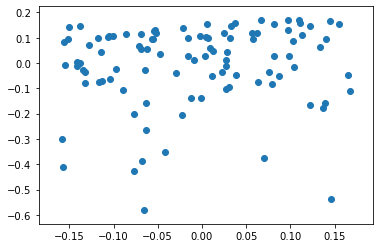

In [19]:
origin_vals = new_data[450:550]
origin_vals_plt = plt.scatter(origin_vals[:,0],origin_vals[:,1])

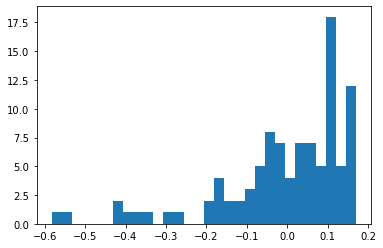

In [20]:
noise_hist = plt.hist(new_data[450:550,1], bins=30)

Looking at these two plots, it looks like the noise was drawn from a heavy tailed distribution (perhaps a beta or gamma distribution?). Additionally, it looks like there may be some cyclilic pattern in the noise, but it is unclear. For now, lets try fitting a function of the form $f(x) = ax^{5}cos(bx)+c$ (growing cosine wave with some room to shift up or down) and see how it fits. 

In [21]:
import scipy.optimize as opt
import random

def loss_fun_1(params_vec, real_points):
    """Given a vector of parameters and an array of the real (x,y) pairs, calculates the y values obtained
    with the function f(x) = ax^bcos(cx)+d and returns the MSE between the estimated y values and the real y
    values"""
    n = real_points.shape[1]
    real_x_vec = real_points[:,0]
    real_y_vec = real_points[:,1]
    
    est_y_vec = params_vec[0]*np.power(real_x_vec, 5)*np.cos(params_vec[1]*real_x_vec)+params_vec[2]
    mse = 1/n *(np.linalg.norm(est_y_vec-real_y_vec))**2
    
    return mse

# Run the scipy optimizer for 100 iterations and return best MSE and parameter estimates
best_mse = -1
best_params = -1
for i in range(100):
    init_params_vec = np.random.randint(-10, 10, (1, 3))
    model = opt.minimize(loss_fun_1, init_params_vec, (new_data))
    
    if model.fun<best_mse or best_mse==-1:
        best_mse = model.fun
        best_params = model.x

est_y_vec = model.x[0]*np.power(new_data[:,0], 5)*np.cos(model.x[1]*new_data[:,0])+model.x[2]
print("Best MSE: " + str(best_mse))
print("Best parameters: " + str(best_params))

/home/zack/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Best MSE: 64.22020661519139
Best parameters: [-0.44229492 -6.24858327 -0.01021605]


Now lets take a look at how well this function fits by plotting our estimated funciton and the real points on top of each other. 

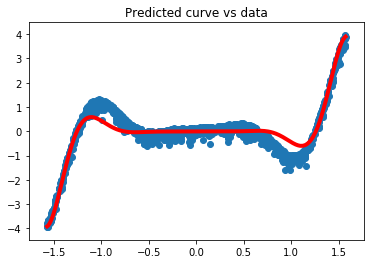

In [22]:
plt.plot(new_data[:,0], est_y_vec, linewidth=4, color="r")
plt.scatter(new_data[:,0], new_data[:,1])
plt.title("Predicted curve vs data")
plt.show()

Obviously this is not a very great fit. Let's instead try to fit to a polynomial and see if we can do better.

In [23]:
def loss_fun_2(y_est, y_real):
    n = len(y_est) # number of training examples
    return 1/n * (np.linalg.norm(y_est-y_real))**2

In [35]:
x_real = new_data[:,0].reshape(1000,1)
y_real = new_data[:,1].reshape(1000,1)

mse_list = []
model_list = []
d_list = []
for i in range(50):
    if i%2 !=0:
        d = i 
        linReg = linear_model.LinearRegression()
        answer_2 = linReg.fit(poly_basis(x_real,d), y_real)
        y_est = answer_2.predict(poly_basis(x_real,d))
        mse = loss_fun_2(y_est, y_real)
        mse_list.append(mse)
        d_list.append(d)
        model_list.append(answer_2)

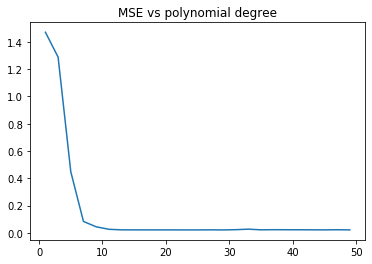

In [36]:
plt.plot(d_list,mse_list)
plt.title("MSE vs polynomial degree")
plt.show()

Since we expect the polynomial fit to get better as we increase the number of degrees allowed, we do not simply want to pick the function with the lowest MSE. Instead, we want to pick the the smallest number of degrees that give a good MSE. Looking at the plot above, this is represented by the "elbow" in the curve. This is the point at which adding more degrees produces only marginal improvements in fit, which is indicative of overfitting. Thus, we will take the 11 degree polynomial.

In [37]:
answer = model_list[5]
print("Estimated coefficients: " + str(answer.coef_))
print("Estimated intercept: " + str(answer.intercept_))

Estimated coefficients: [[ 0.          0.71829991 -0.21847127 -1.29181097  0.59753715 -3.69860569
  -0.61613181  4.1711349   0.27046169 -0.95334595 -0.04268387]]
Estimated intercept: [0.0137282]
